In [7]:
import numpy as np, os, sys
sys.path.append("..")
import wandb

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data
from src.models import DeepCNNModel
from src.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve
from src.utils import metrics

import matplotlib as mpl 
from matplotlib import pyplot as plt 
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [2]:
# get data 
savedir = "./data"
# _=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 35,
    "patience": 3,
    }

In [5]:
WANDB= False
if WANDB:

    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="deep_cnn_synthetic_aug3",

        # track hyperparameters and run metadata
        config=config
    )

In [6]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'])


In [8]:
# set up the model, lossfn, optimizer, trainer 
model = DeepCNNModel()
lossfn = nn.BCEWithLogitsLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Set up the learning rate scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

metrics_list = [getattr(metrics, met) for met in ['accuracy', 'auroc']]

trainer = Trainer(model, lossfn, optimizer, lr_scheduler=scheduler, metrics=metrics_list, wandb=False)
history = trainer.fit(
            loaders['train'], 
            val_loader=loaders['valid'], 
            nepochs=config['epochs'], 
            patience=config['epochs'],
            save_path='deep_cnn_best_model.pt'
                    )

Model saved at epoch 1, val_loss: inf -> 0.5433
Epoch:   1/35, loss: 0.5559, accuracy: 0.5009, auroc: 0.7885, val_loss: 0.5433, val_accuracy: 0.5105, val_auroc: 0.8627
Model saved at epoch 2, val_loss: 0.5433 -> 0.5013
Epoch:   2/35, loss: 0.4669, accuracy: 0.5019, auroc: 0.8668, val_loss: 0.5013, val_accuracy: 0.5108, val_auroc: 0.8912
Epoch:   3/35, loss: 0.4130, accuracy: 0.5014, auroc: 0.8999, val_loss: 0.6298, val_accuracy: 0.5133, val_auroc: 0.9156
Epoch:   4/35, loss: 0.3784, accuracy: 0.5026, auroc: 0.9183, val_loss: 0.5261, val_accuracy: 0.5145, val_auroc: 0.9430
Model saved at epoch 5, val_loss: 0.5013 -> 0.4305
Epoch:   5/35, loss: 0.3354, accuracy: 0.5031, auroc: 0.9369, val_loss: 0.4305, val_accuracy: 0.5113, val_auroc: 0.9477
Model saved at epoch 6, val_loss: 0.4305 -> 0.3650
Epoch:   6/35, loss: 0.3194, accuracy: 0.5031, auroc: 0.9462, val_loss: 0.3650, val_accuracy: 0.5112, val_auroc: 0.9543
Epoch:   7/35, loss: 0.2888, accuracy: 0.5039, auroc: 0.9545, val_loss: 0.4793,

In [9]:
model.load_state_dict(torch.load("deep_cnn_best_model.pt"));

In [10]:
model = model.to("cpu")
ytest, ytestpred = [], []
for batch in loaders['test']:
    xtest, _ytest = batch
    _ytestpred = torch.sigmoid(model(xtest)).argmax(1).detach().numpy()
    ytestpred.append(_ytestpred)
    ytest.append(_ytest)
ytest = np.hstack(ytest)
ytestpred = np.hstack(ytestpred)
print((ytest == ytestpred).sum() / len(ytest))



0.49625


In [11]:
history.keys()

dict_keys(['loss', 'accuracy', 'auroc', 'val_loss', 'val_accuracy', 'val_auroc'])

In [12]:
import torchmetrics

confmat = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)
print(confmat(torch.tensor(ytestpred), torch.tensor(ytest)))
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
print(accuracy(torch.tensor(ytestpred), torch.tensor(ytest)))
# auroc = torchmetrics.AUROC(task="multiclass", num_classes=2)
# print(auroc(torch.tensor(ytestpred), torch.tensor(ytest)))


tensor([[1985,    0],
        [2015,    0]])
tensor(0.4963)


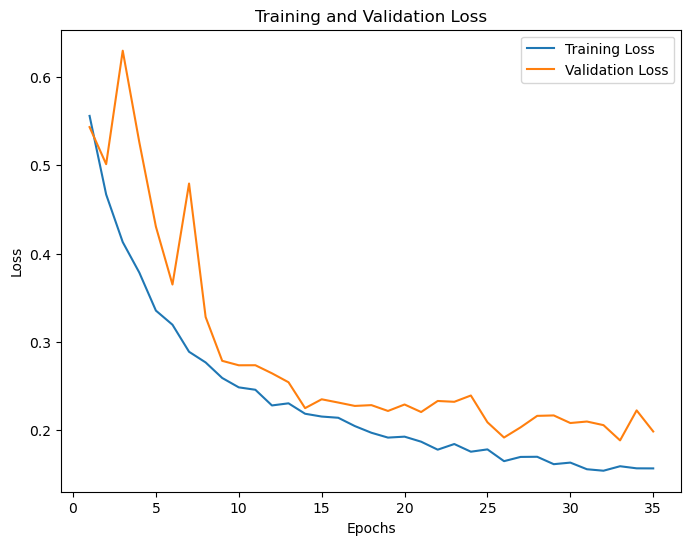

In [13]:
# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.9823


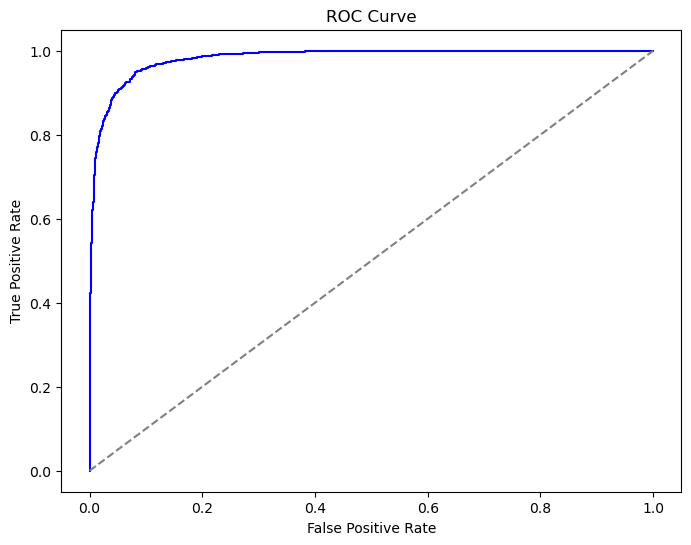

In [14]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [14]:
wandb.finish()